In [35]:
a = 10
a

10

In [ ]:
# This code  contains
# 1. Code to generate light curve using BATMAN | cut it | interpolat it
# 2. Code to save and load flux values
# 3. Code to ML Model and predict shapes

In [36]:
import batman
import numpy as np
import matplotlib.pyplot as plt



In [37]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period
params.rp = 0.22                      #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5, 0.05]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

In [38]:
flux = m.light_curve(params)                    #calculates light curve


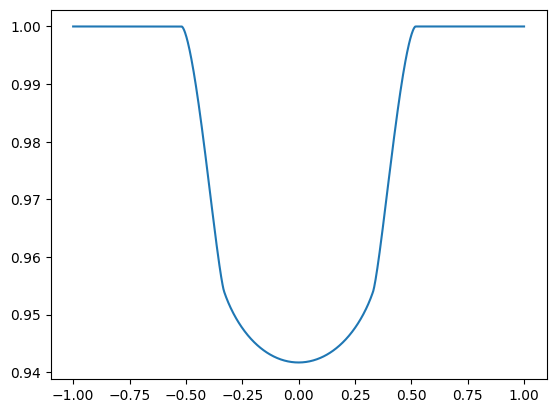

In [39]:
phase = np.linspace(-1,1,len(flux))
plt.plot(phase,flux)
plt.show()

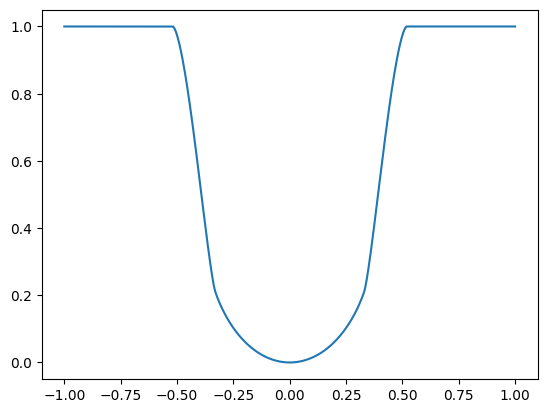

In [40]:
# Normalize light curve
flux_scaled = np.copy(flux)
flux_scaled = (flux - np.amin(flux))/(np.amax(flux) - np.amin(flux))

phase = np.linspace(-1,1,len(flux_scaled))
plt.plot(phase,flux_scaled)
plt.show()

Length of batman lc =  1000
center_index =  500
left_index =  166
right_index =  834


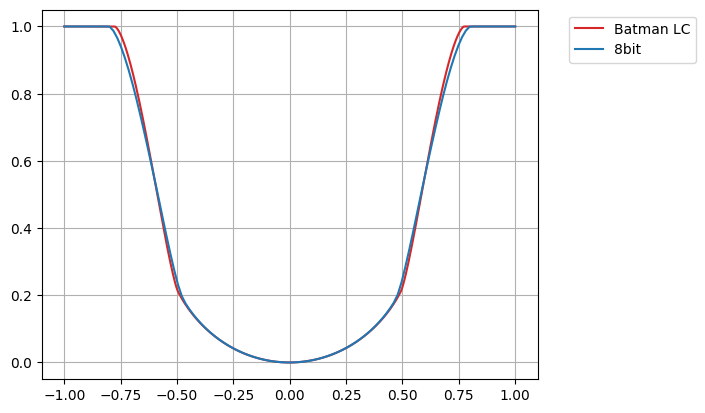

In [41]:
# Cut light curve

# flux_scaled_mask used to select the flat part by certain percentage
flux_scaled_mask = np.copy(flux_scaled)

flux_scaled_mask[flux_scaled_mask>=0.98] = 1.0
flux_scaled_mask[flux_scaled_mask<0.98] = 0.0

print("Length of batman lc = ",len(flux_scaled_mask))

count_zeros = np.count_nonzero(flux_scaled_mask == 0)  

center_index = int(len(flux_scaled)/2)
print("center_index = ",center_index)

left_index = int(center_index - int(count_zeros/2)-int(count_zeros/6)) 
right_index = int(center_index + int(count_zeros/2)+int(count_zeros/6))
print("left_index = ",left_index)
print("right_index = ",right_index)
lc_test=flux_scaled[left_index:right_index+1] # Cut light curve

plt.plot(np.linspace(-1,1,len(lc_test)),lc_test,label='Batman LC',color="tab:red")
# ax.scatter(np.linspace(-1,1,len(train_lc_scaled_append[0])),train_lc_scaled_append[0],label='Simulated LC',color="tab:red",s=1)


# 8bit_lc
lc_8bit = np.loadtxt("circle8bit_0_5_0_005.csv", delimiter=',')
lc_8bit = np.reshape(lc_8bit,(1,len(lc_8bit),1))
plt.plot(np.linspace(-1,1,len(lc_8bit[0])),lc_8bit[0],label='8bit')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.grid('on')
plt.show()

Length of cut lc =  669
length =  120


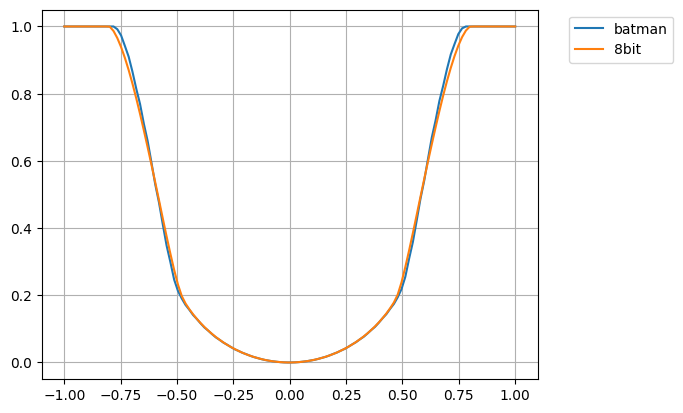

In [42]:
# Interpolate/Sample light curve
print("Length of cut lc = ",len(lc_test))
def down_sample(to_down_sample_lc):
        to_down_sample = to_down_sample_lc
        dwn_sample_idx = np.round(np.linspace(0, len(to_down_sample_lc) - 1, 120)).astype(int)
        down_sample_lc = to_down_sample[dwn_sample_idx]
        return down_sample_lc

lc_test_sampled = down_sample(lc_test)
print('length = ',len(lc_test_sampled))
plt.plot(np.linspace(-1,1,len(lc_test_sampled)),lc_test_sampled,label='batman')

plt.plot(np.linspace(-1,1,len(lc_8bit[0])),lc_8bit[0],label='8bit')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid('on')
plt.show()

In [43]:
np.savetxt("planet_0_5_0_005_v2.csv", lc_test_sampled, delimiter=',')


In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
import numpy as np


2024-01-24 19:20:44.361338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 19:20:46.847304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


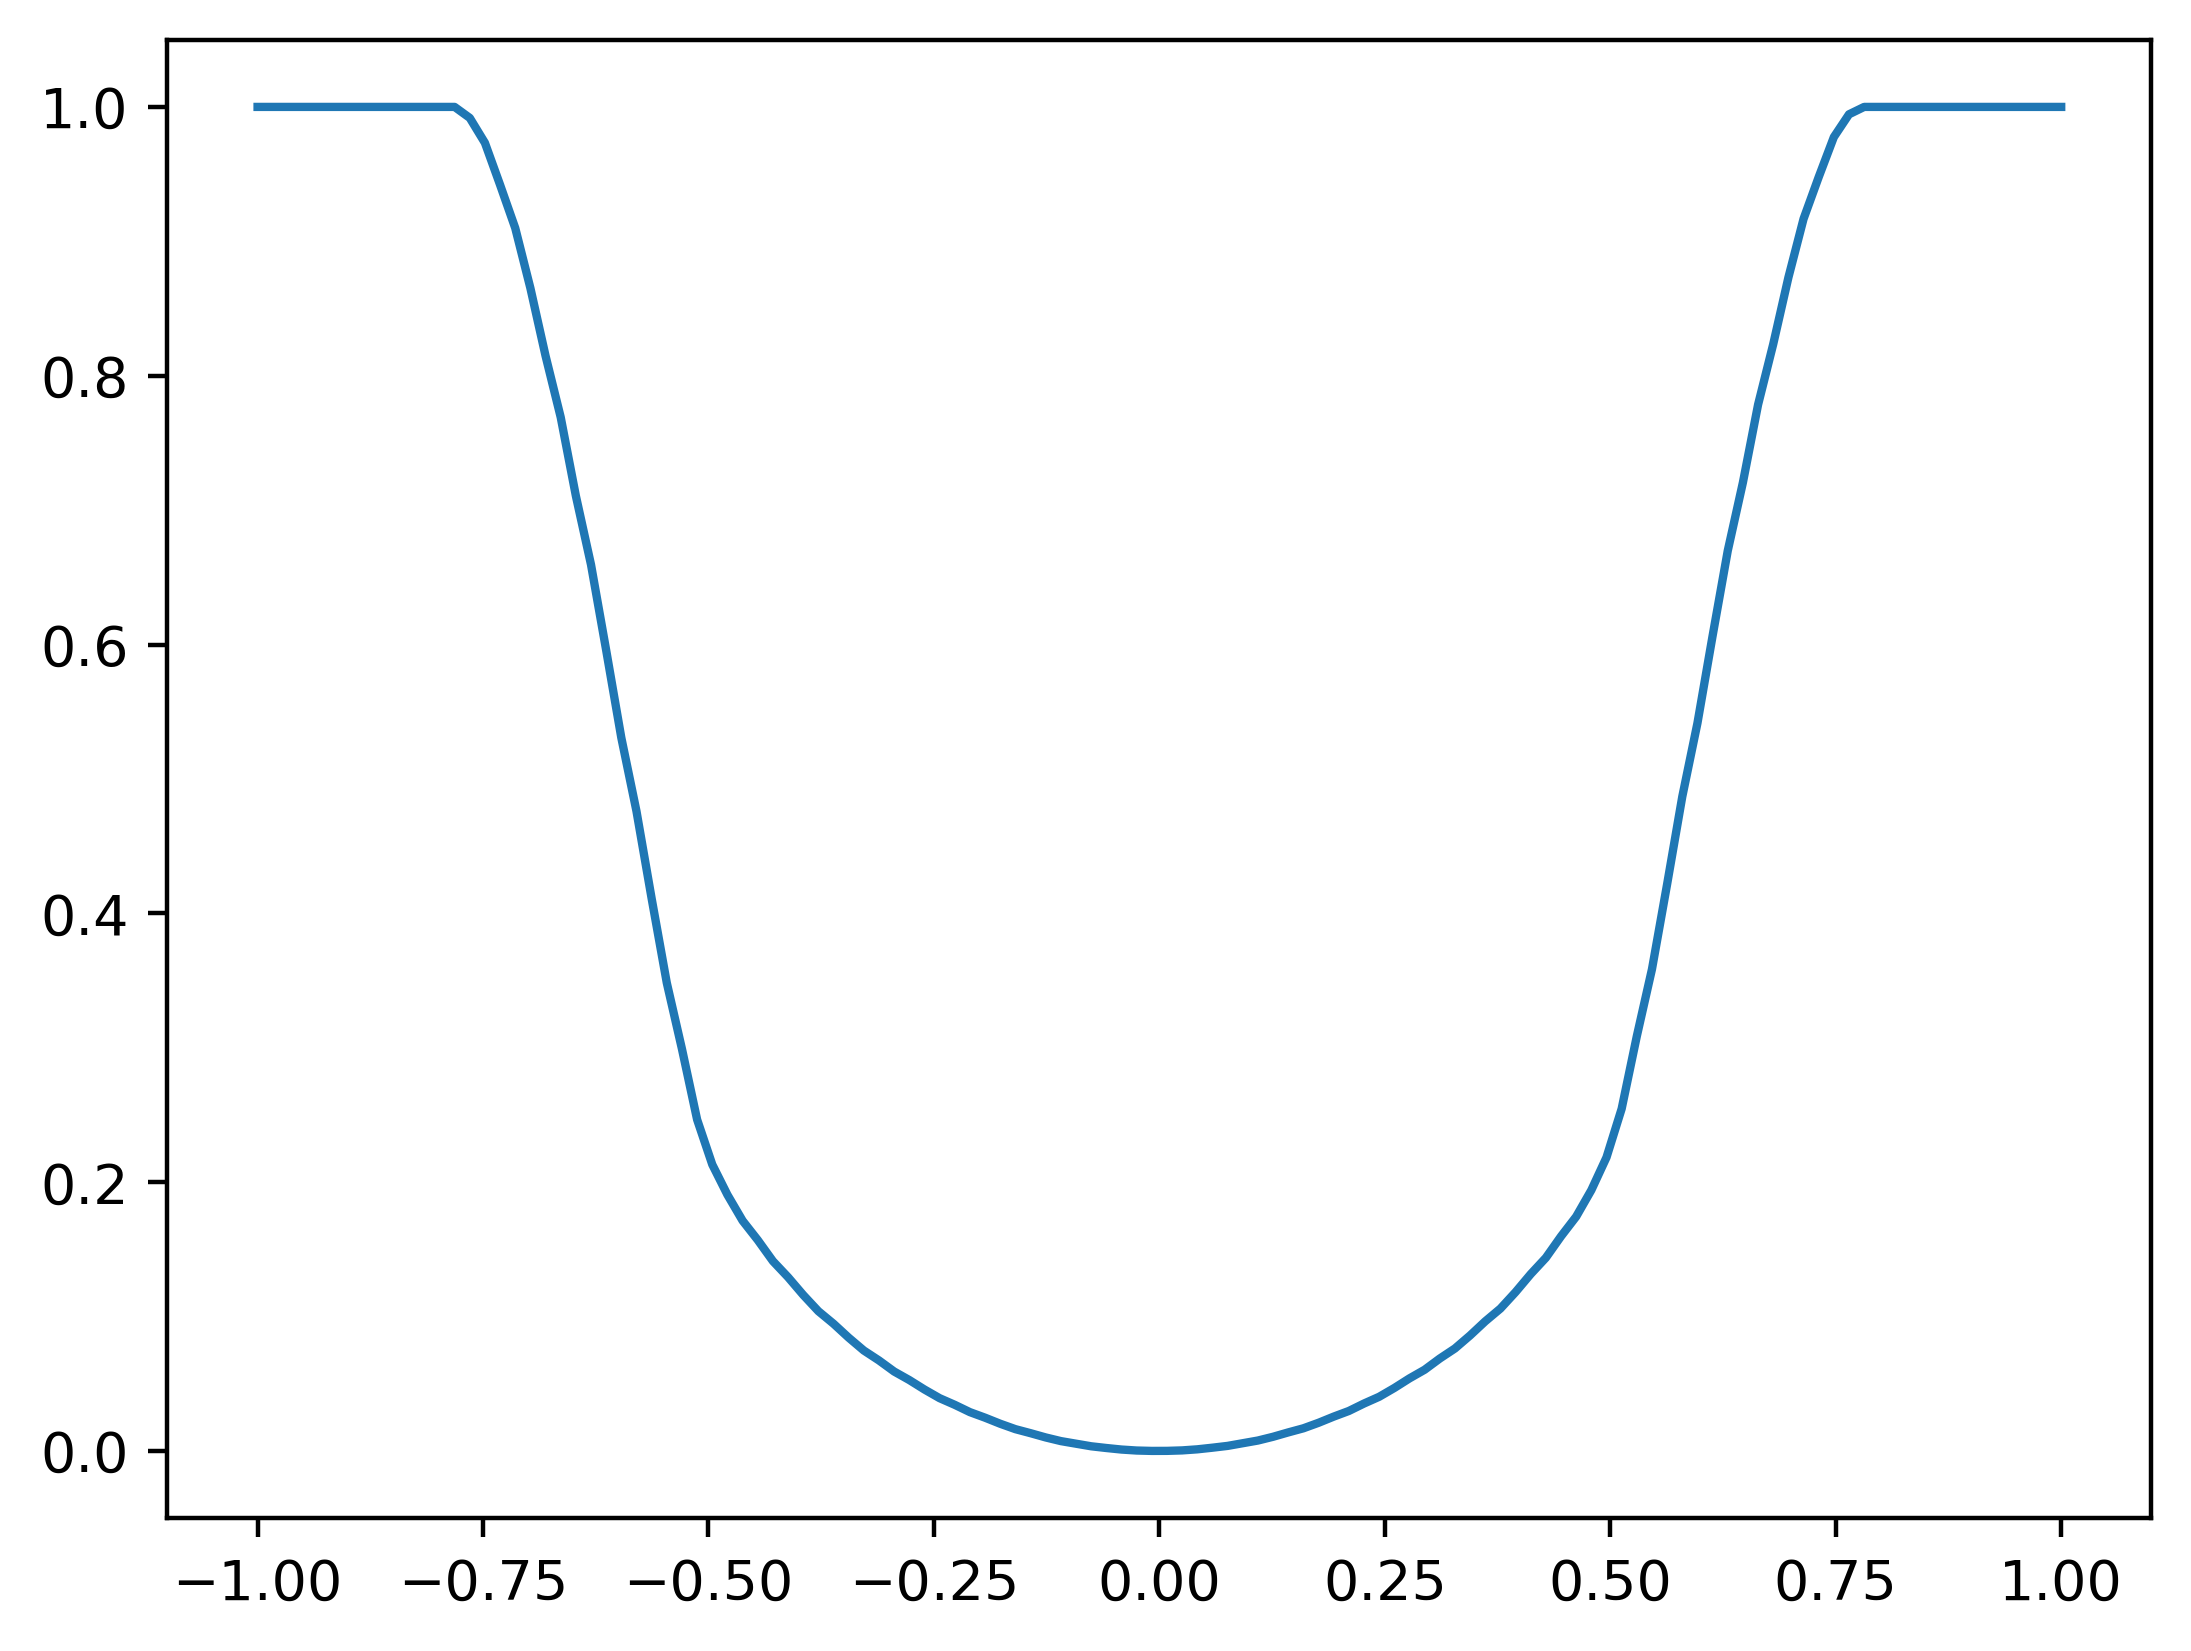

In [2]:
lc_test_sampled = np.loadtxt("planet_0_5_0_005_v2.csv", delimiter=',')
lc_test_sampled = np.reshape(lc_test_sampled,(1,len(lc_test_sampled),1))
plt.plot(np.linspace(-1,1,len(lc_test_sampled[0])),lc_test_sampled[0])
plt.show()

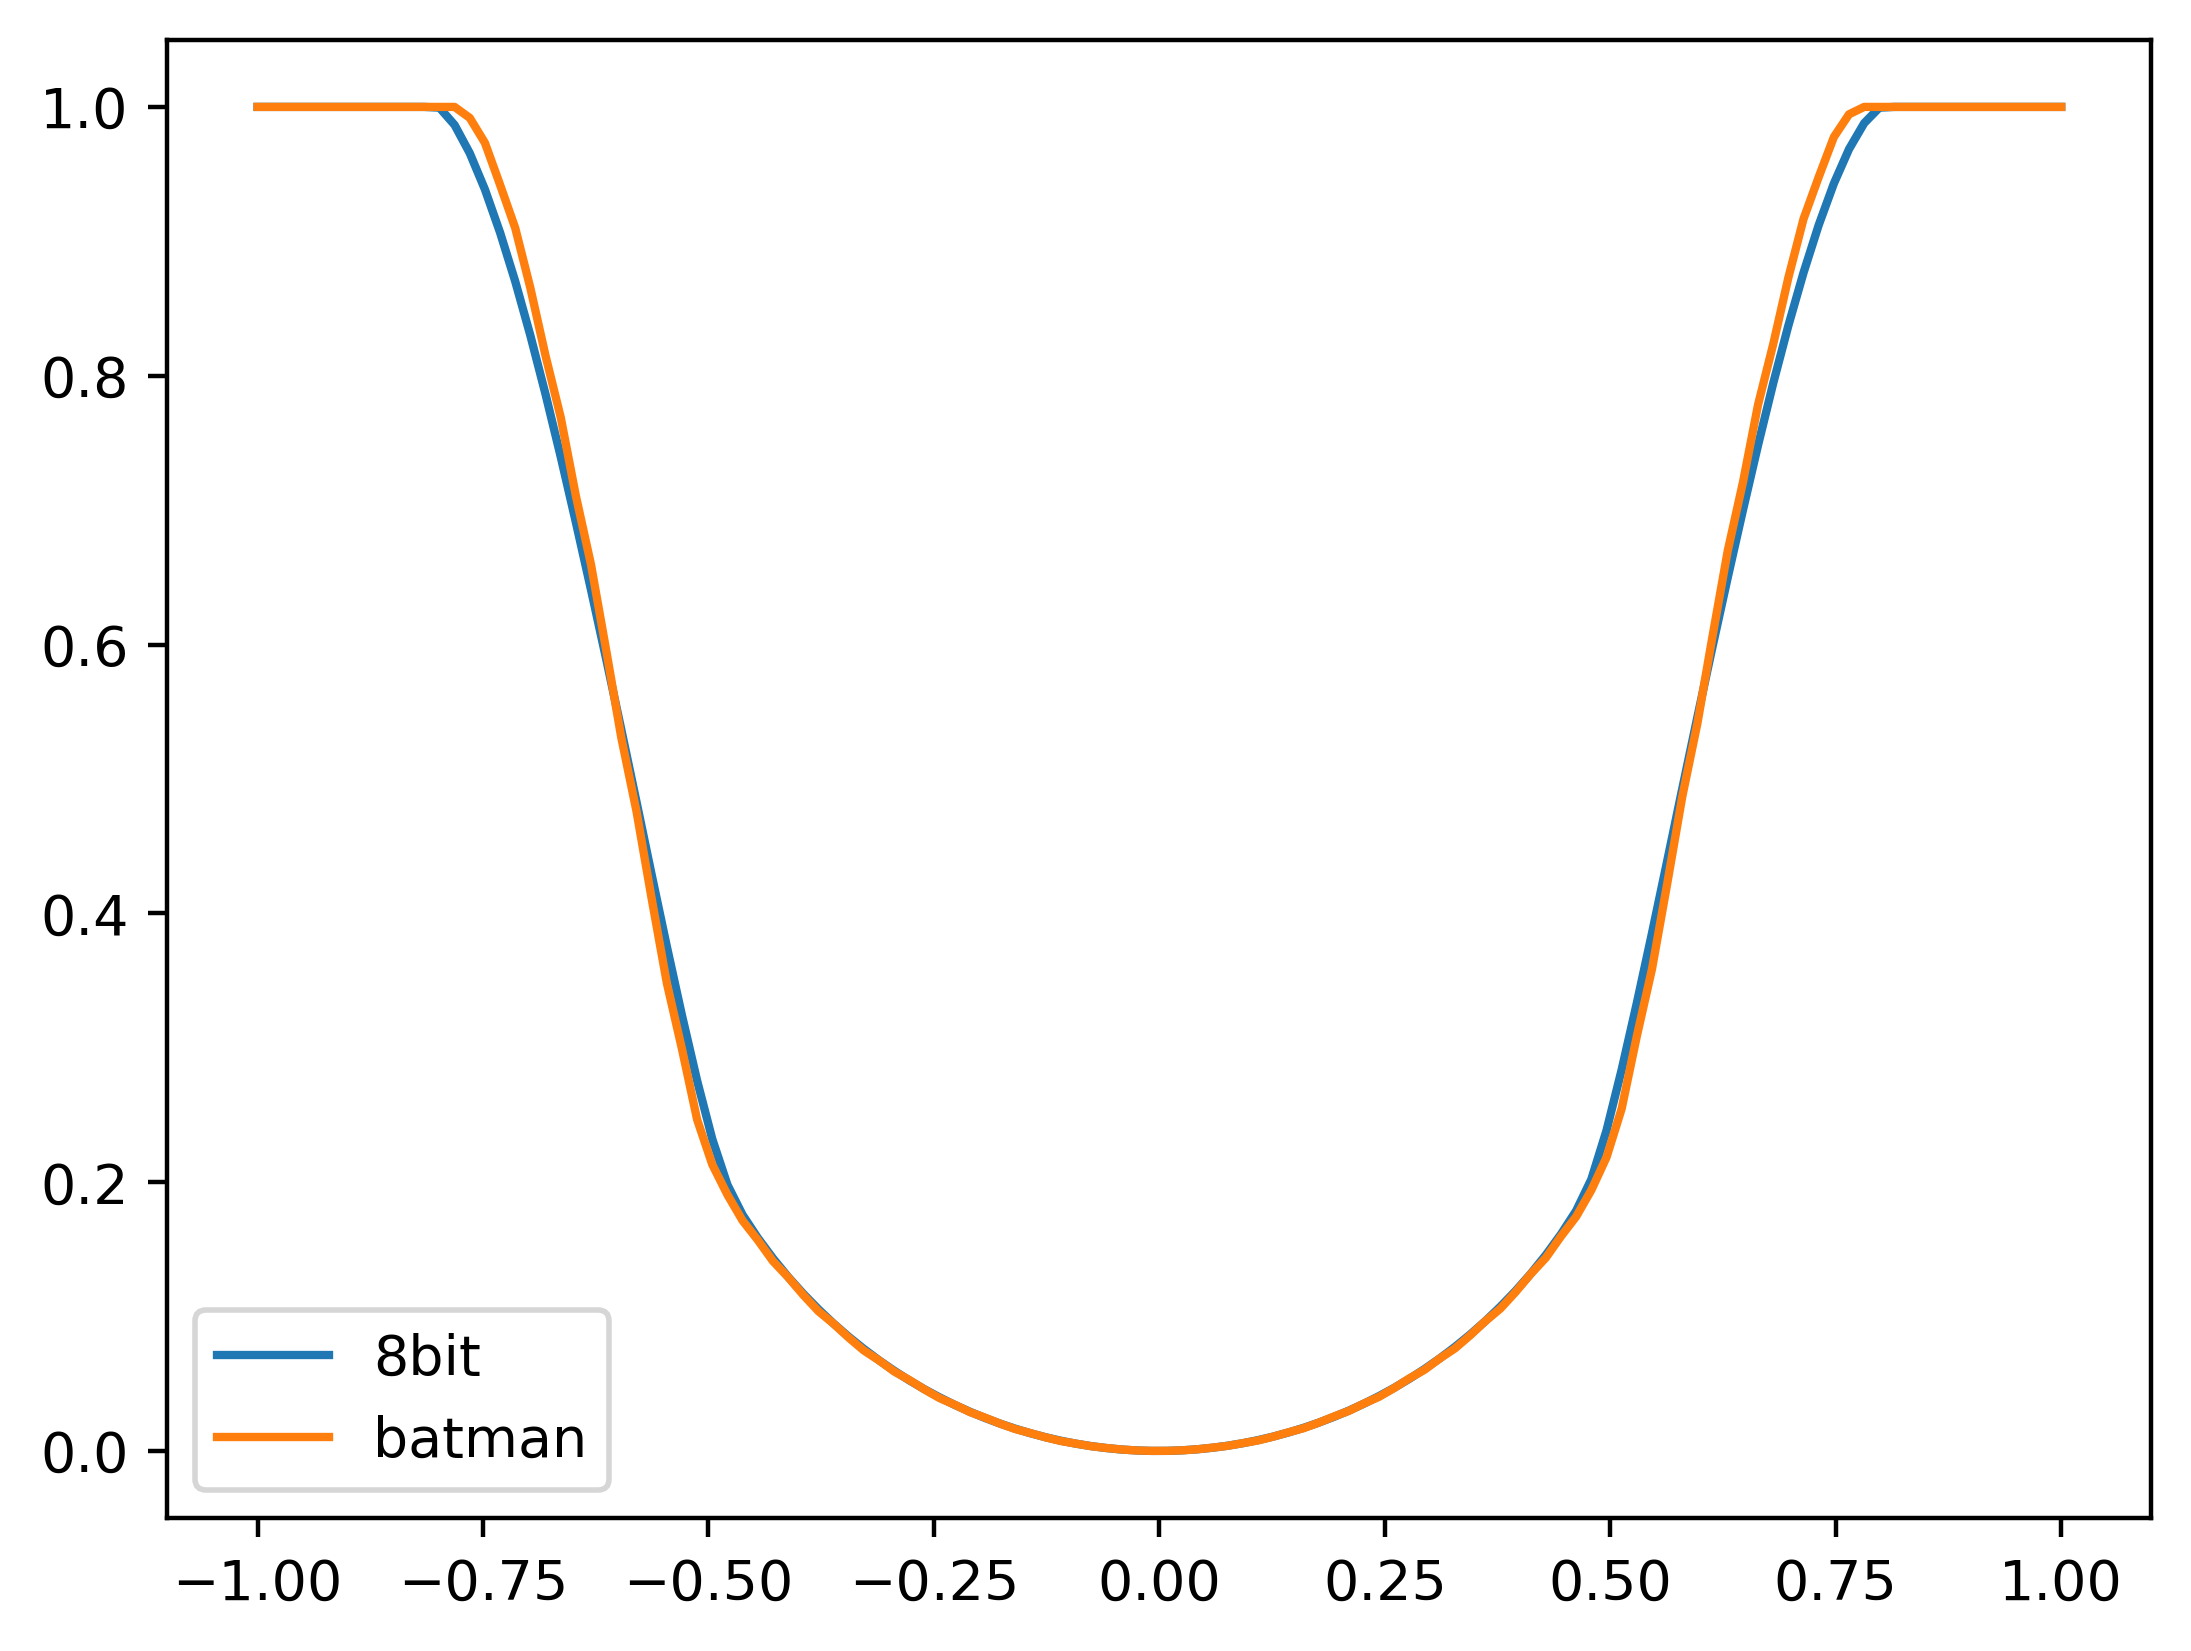

In [3]:
lc_8bit = np.loadtxt("circle8bit_0_5_0_005.csv", delimiter=',')
lc_8bit = np.reshape(lc_8bit,(1,len(lc_8bit),1))
plt.plot(np.linspace(-1,1,len(lc_8bit[0])),lc_8bit[0],label='8bit')
plt.plot(np.linspace(-1,1,len(lc_test_sampled[0])),lc_test_sampled[0],label='batman')
plt.legend()
plt.show()

In [4]:
# Load ML Model
# # ML Prediciton
# model_load = load_model("../ml_model/sep22_singleModel_uniform_SNR/model_sep22_unf_50_500_v1.h5")
# Model trained on 9 LDCs
model_load = load_model("/scratch/abraham/Documents/mega_git/mega/ml_model/nov13_model1/nov13_model1_sample_interpolate_no_noise_unf_samplept_20to60.h5")

# model_load.summary()

# Predict shape
local_view_predict_shape = model_load.predict(lc_test_sampled)
# local_view_predict_shape = model_load.predict(lc_8bit)
test_predict_shape_normalized = np.zeros(local_view_predict_shape.shape[:])
test_predict_shape_normalized = (local_view_predict_shape - np.amin(local_view_predict_shape))/(np.amax(local_view_predict_shape) - np.amin(local_view_predict_shape))
print("Normalized the predicted shape")
local_view_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

2024-01-24 19:21:13.281488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12004 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 120)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 120, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 120, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 120, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 120, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 60, 16)            0         
                                             

2024-01-24 19:21:15.085248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 2s 2s/step
Normalized the predicted shape


In [6]:
def binarize_predicted_image(org_image_array):
    # binarize_predicted_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]),int(org_image_array.shape[2])))
    binarize_predicted_image_array = np.copy(org_image_array)
    binarize_predicted_image_array[binarize_predicted_image_array>=0.2] = 1
    binarize_predicted_image_array[binarize_predicted_image_array<0.2] = 0
    return(binarize_predicted_image_array)

binarize_predicted_image_array = binarize_predicted_image(local_view_predict_shape)


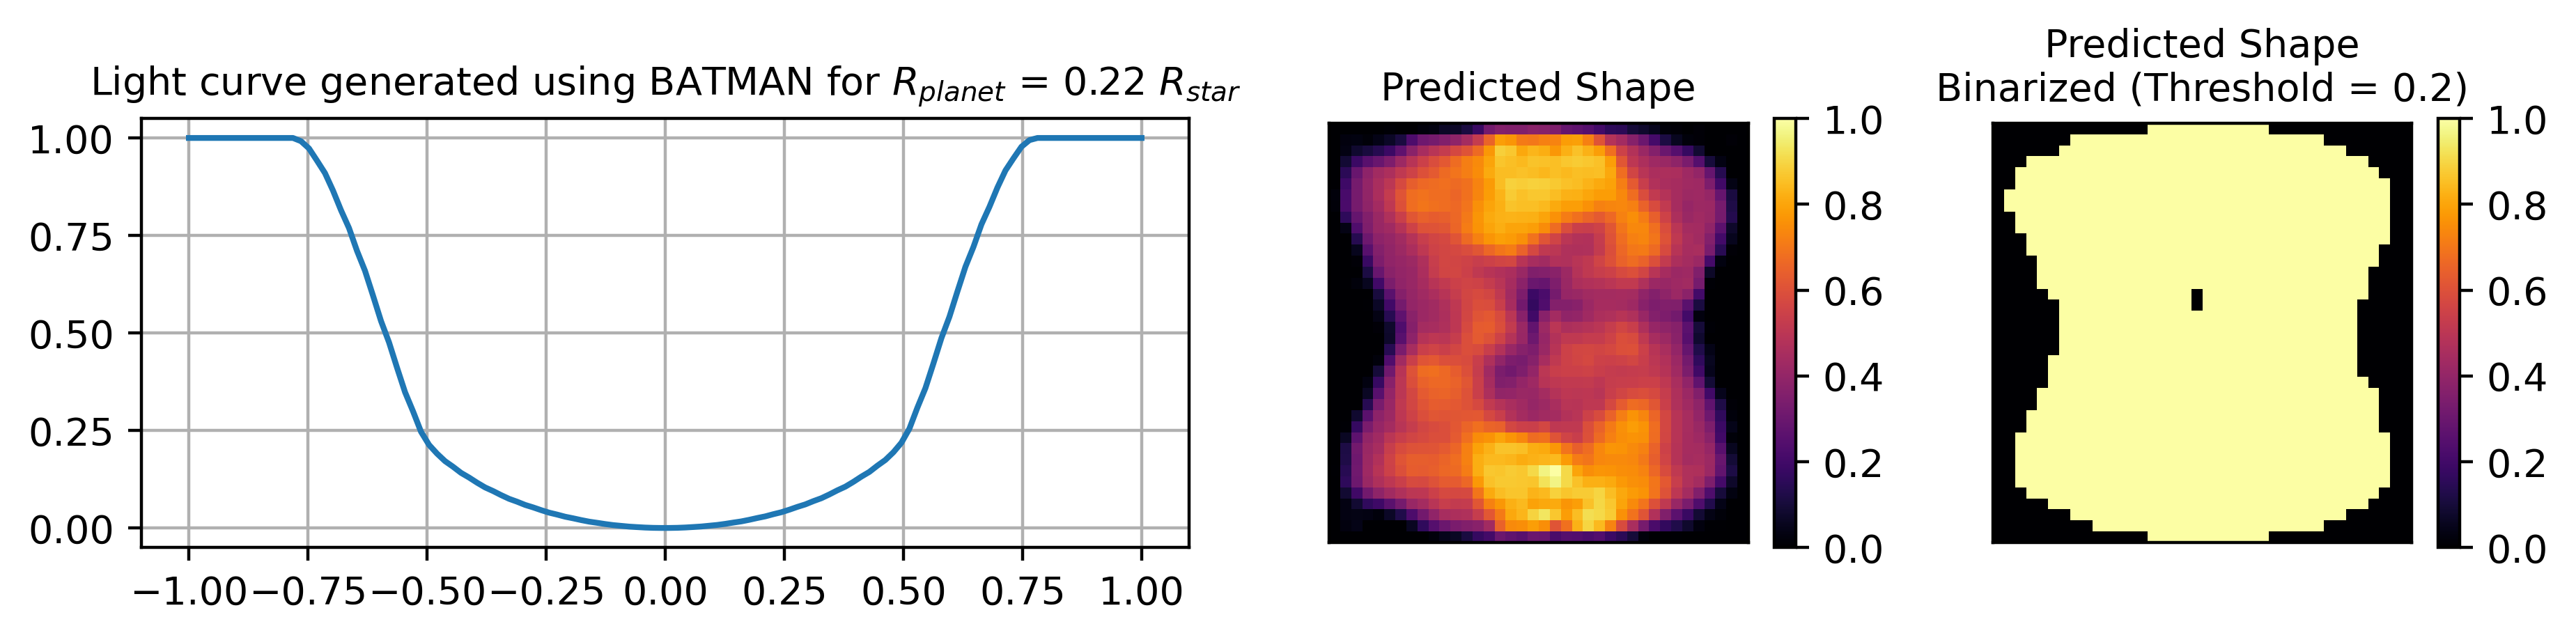

In [9]:
# plot the prediction of a single Kepler light curve
# you can give the index

# Plotting with binarizing also
plt.rcParams['figure.dpi'] = 400
fig,ax=plt.subplots(1,3, figsize=(11,2), gridspec_kw={ 'width_ratios': [2,1,1],
'wspace': 0.2,'hspace': 0.4})

ax[0].set_title(r'Light curve generated using BATMAN for $R_{planet}$ = 0.22 $R_{star}$',size=10)
ax[0].plot(np.linspace(-1.0,1.0,len(lc_test_sampled[0])),lc_test_sampled[0])
ax[0].grid('on')

ax[1].set_title(f'Predicted Shape',size=10)
img = ax[1].imshow(local_view_predict_shape[0],cmap='inferno')
plt.colorbar(img)
ax[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

ax[2].set_title(f'Predicted Shape\nBinarized (Threshold = 0.2)',size=10)
img = ax[2].imshow(binarize_predicted_image_array[0],cmap='inferno')
plt.colorbar(img)
ax[2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)


In [ ]:
# Subtract 8bit and batman
